<a href="https://colab.research.google.com/github/ana-rlopez/ny_taxi_fare_prediction/blob/master/NYTaxiFare_1_ExploratoryAnalysis_%26_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from geopy.distance import vincenty
from yellowbrick.target import FeatureCorrelation
import sklearn

In [0]:
from google.colab import drive
drive.mount('/content/drive')
train_path = '/content/drive/My Drive/Colab Notebooks/train.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv(train_path, nrows=1_000_000) #we don't select all rows, since it is a big dataset
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
#check if there are some NaN values
train.columns[train.isna().any()].tolist()

['dropoff_longitude', 'dropoff_latitude']

In [0]:
#we drop these values given that the data set is quite big
#original rows: 1_000_000
train.dropna(inplace=True)
train.shape[0]

999990

In [0]:
#drop duplicates
train.drop_duplicates(keep = 'first', inplace = True)
train.shape[0]

999990

In [0]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [0]:
train['key'] = pd.to_datetime(train['key'])
train.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime              object
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [0]:
#add features related with datetime
train['weekday'] = train['key'].dt.dayofweek
train['year']=train['key'].dt.year
train['month']=train['key'].dt.month
train['day']=train['key'].dt.day
train['hour']=train['key'].dt.hour
train['minute']=train['key'].dt.minute #needed?
train['second']=train['key'].dt.second

In [0]:
train.describe()
#check the describe to see if their values make sense

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour,minute,second
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941,3.039870,2011.741103,6.267841,15.697996,13.509463,29.566313,15.868546
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907,1.949966,1.860761,3.436230,8.682472,6.513855,17.322462,19.441629
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000,1.000000,2010.000000,3.000000,8.000000,9.000000,15.000000,0.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000,3.000000,2012.000000,6.000000,16.000000,14.000000,30.000000,4.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000,5.000000,2013.000000,9.000000,23.000000,19.000000,45.000000,32.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000,6.000000,2015.000000,12.000000,31.000000,23.000000,59.000000,59.000000


In [0]:
#based on these descriptors, we can at first sight already remove some outliers:
#1) Latitudes range from -90 to 90. Longitudes range from -180 to 180.
#2) passengers in a taxi, up to 6 (icnluding suvs) https://ride.guru/lounge/p/how-many-people-can-ride-in-a-cab 
#leave drives of 0 passengers in case documents are transported?
#3) fare has to be positive value, over 2.50$ (that seems to be the initial charge) https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

train = train[ (train.pickup_longitude >= -180) & (train.pickup_longitude <= 180) & \
              (train.dropoff_longitude >= -180) & (train.dropoff_longitude <= 180) & \
              (train.pickup_latitude >= -90) & (train.pickup_latitude <= 90) & \
              (train.dropoff_latitude >= -90) & (train.dropoff_latitude <= 90) & \
              (train.passenger_count<= 6) & \
              (train.fare_amount > 2.50) ]


In [0]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour,minute,second
count,995869.000000,995869.000000,995869.000000,995869.000000,995869.000000,995869.000000,995869.000000,995869.000000,995869.000000,995869.000000,995869.000000,995869.000000,995869.000000
mean,11.384606,-72.538546,39.938402,-72.545370,39.942431,1.685512,3.039752,2011.741729,6.268162,15.696453,13.512886,29.567612,15.860323
std,9.824825,10.321153,6.052619,10.294233,6.041147,1.308085,1.949960,1.860230,3.436376,8.682534,6.513688,17.322834,19.440094
min,2.510000,-128.175950,-74.016587,-121.391248,-74.035197,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992067,40.735013,-73.991391,40.734097,1.000000,1.000000,2010.000000,3.000000,8.000000,9.000000,15.000000,0.000000
50%,8.500000,-73.981807,40.752720,-73.980153,40.753192,1.000000,3.000000,2012.000000,6.000000,16.000000,14.000000,30.000000,4.000000
75%,12.500000,-73.967155,40.767174,-73.963739,40.768147,2.000000,5.000000,2013.000000,9.000000,23.000000,19.000000,45.000000,32.000000
max,500.000000,40.850357,69.400000,45.581619,81.510177,6.000000,6.000000,2015.000000,12.000000,31.000000,23.000000,59.000000,59.000000


In [0]:
#maybe convert time (hours and minutes) to circular, given that then the correlation may be more easily seen
#seconds_in_day = 24*60*60

#train['full_time'] = train.hour*60*60 + train.minute*60 + train.second #time of the day in seconds
#train['sin_time'] = np.sin(2*np.pi*train.full_time/seconds_in_day)
#train['cos_time'] = np.cos(2*np.pi*train.full_time/seconds_in_day)
#train.drop('full_time', axis=1, inplace=True)

#note: checked that these 2 feats are computed ok (proper ranges)

In [0]:
#Instead of doing Harvestine distance (that assumes Earth is a sphere), here Vincenty distance is used,
#which employs more accurate ellipsoidal models

# (latitude, longitude) reminder
train ['distance'] = train.apply(lambda x: vincenty((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).meters, axis = 1)
#train['distance'] = train.apply(
#    (lambda row: vincenty(
#        (row['LATITUDE'], row['LONGITUDE']),
#       (row['LAT'], row['LON'])
#    ).miles),
#    axis=1
#)

In [0]:
train['distance']

0         1029.600743
1         8443.441355
2         1389.132157
3         2795.789657
4         1998.337832
             ...     
999995    1881.757790
999996       0.000000
999997    1762.922520
999998    1840.447683
999999     758.924994
Name: distance, Length: 995869, dtype: float64

In [0]:
train.describe().loc[['min','max']]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour,minute,second,distance
min,2.51,-128.175950,-74.016587,-121.391248,-74.035197,0.0,0.0,2009.0,1.0,1.0,0.0,0.0,0.0,0.000000e+00
max,500.00,40.850357,69.400000,45.581619,81.510177,6.0,6.0,2015.0,12.0,31.0,23.0,59.0,59.0,1.260287e+07


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f083f8a4400>,
      dtype=object)

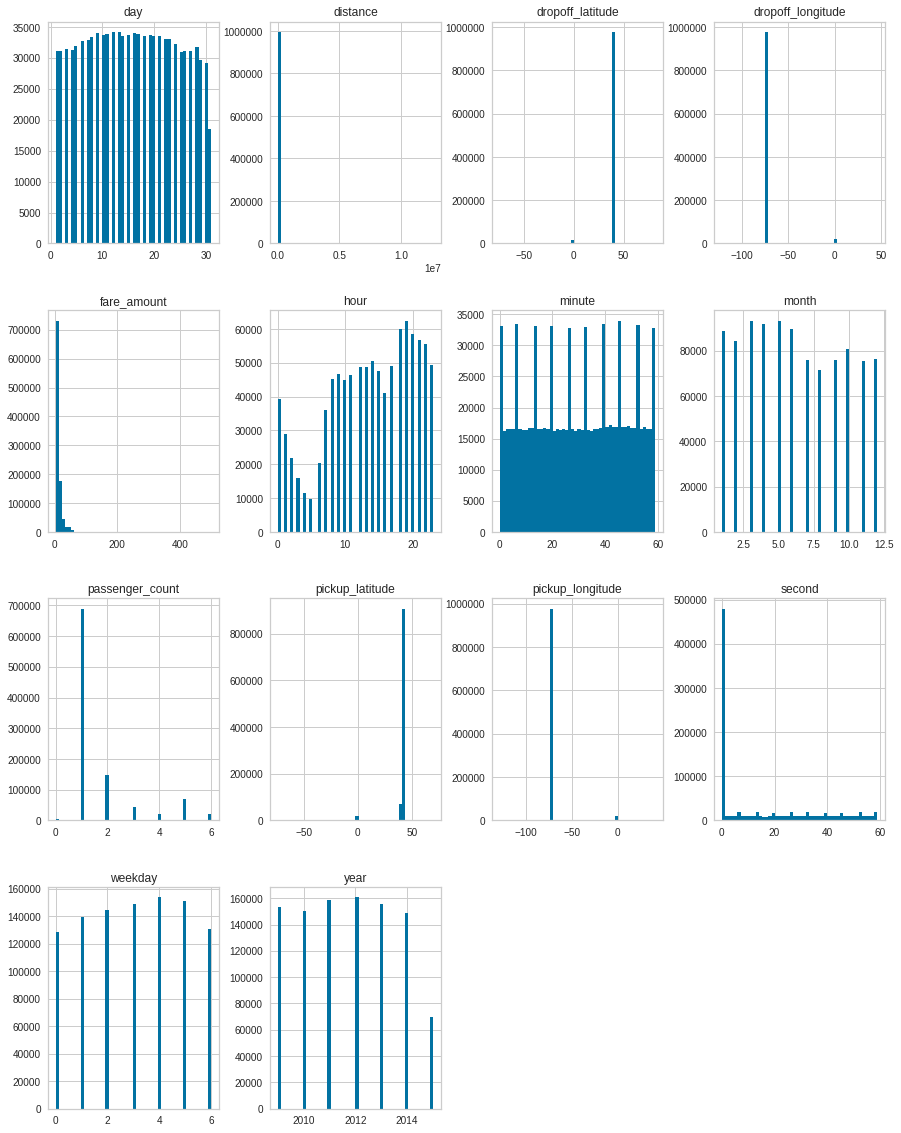

In [0]:
#check distributions of all the features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train.hist(ax = ax, bins=50)


In [0]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1

In [0]:
#automatic outlier removal, to try and get more normal distributions
#https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba?gi=8548f80fce4b
train_out = train.drop(['key','pickup_datetime'],axis=1, inplace=False)

train_out = train_out[~((train_out < (Q1 - 1.5 * IQR)) |(train_out > (Q3 + 1.5 * IQR))).any(axis=1)]

train.shape

(995869, 16)

In [0]:
train_out.shape

(745294, 14)

In [0]:
#this doesn't help (before or after outlier removal)
#Also did log for all feats instead of outlier removal, but it doesnt work much
#train_out['distance'] = train_out['distance'].transform(lambda x: np.log(x+sys.float_info.epsilon))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f083b28f358>,
      dtype=object)

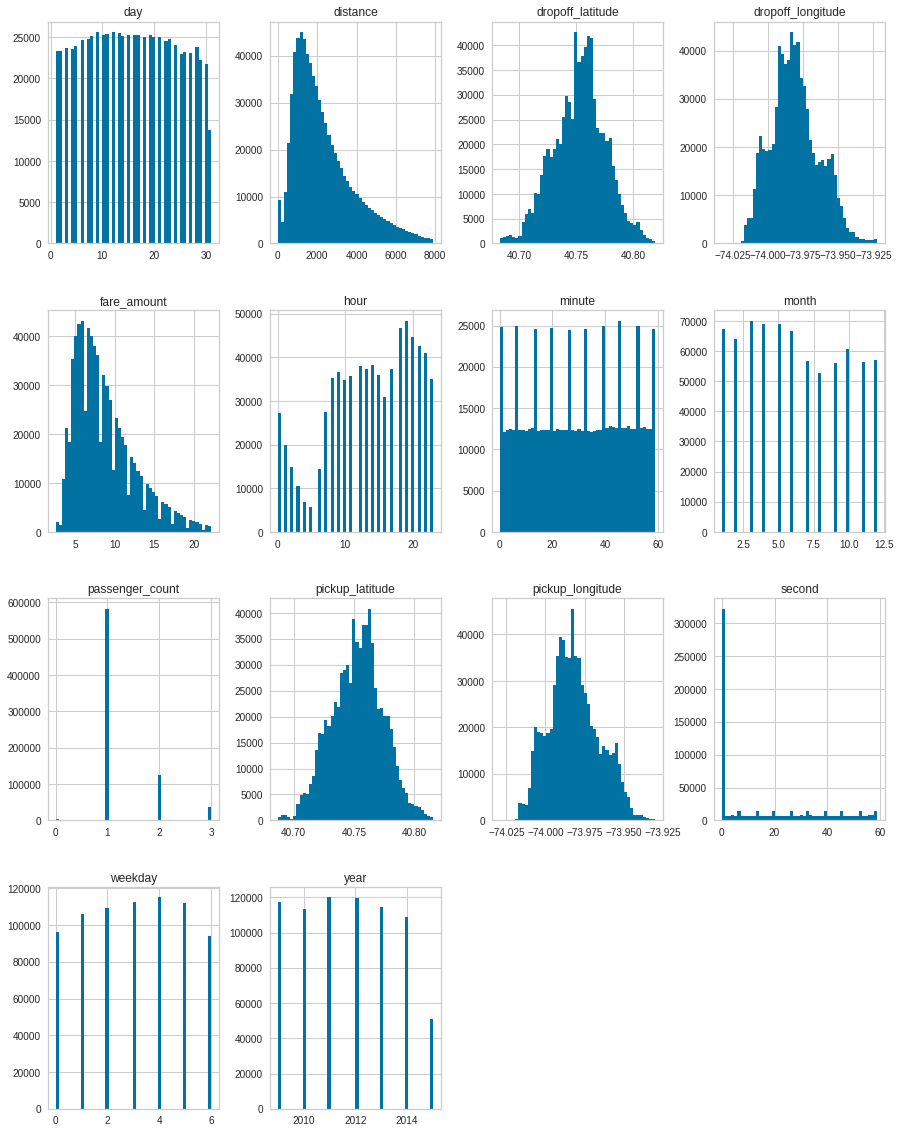

In [0]:
#check distributions of all the features
fig2 = plt.figure(figsize = (15,20))
ax2 = fig2.gca()
train_out.hist(ax = ax2, bins=50)

In [0]:
corr_pearson = train_out.corr(method='pearson')
mask = np.zeros_like(corr_pearson, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

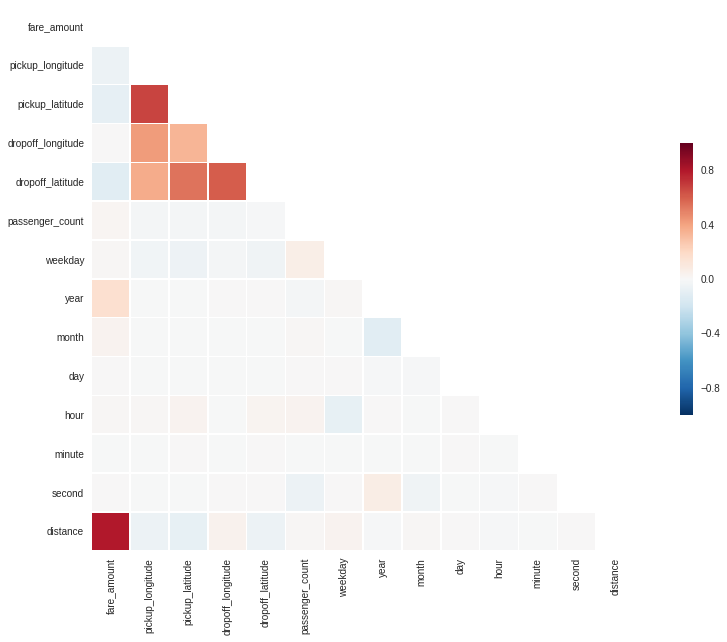

In [0]:
fig4, ax4 = plt.subplots(figsize=(16, 10))
sns.heatmap(corr_pearson, mask=mask, cmap='RdBu_r', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},vmin=-1)

In [0]:
#visualizer = FeatureCorrelation( method='mutual_info-classification', feature_names=train_out.columns, sort=True)
X = train_out.drop('fare_amount',axis=1, inplace=False).to_numpy()
Y = train_out.fare_amount.to_numpy()
#lab_enc = sklearn.preprocessing.LabelEncoder()
#Y_encoded = lab_enc.fit_transform(Y)

feature_MIscores = sklearn.feature_selection.mutual_info_regression(X, Y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)[source]

#visualizer.fit(X, Y)        # Fit the data to the visualizer
#visualizer.show()              # Finalize and render the figure

In [0]:
#plot also the fare vs the date (year), and maybe check as hypothesis if there is a positive correlation between year and fare

In [0]:
X.shape

(745294, 16)

In [0]:
#maybe also plot histograms grouping by day, or by hour, to see what times are more common, and see if the fair is similar for 

In [0]:
#maybe a heat map of the fares would be interesting, doing a geomap, maybe use plotly?